# Traitement fichier monmaster pour générer score (tentative)

In [1]:
import pandas as pd

# Charger les données Excel
df = pd.read_excel(r"C:\Users\GODLEWSKI\Downloads\M1 AES CALGR.xlsx")

# Liste des diplômes prioritaires
priority_diplomas = ['Licence', 'Diplôme de comptabilité et de gestion (DCG)', 'Bachelor universitaires de technologie (BUT)']

# Créer une nouvelle colonne 'Diploma' avec des valeurs de priorité
df['Diploma'] = df['Type de formation ou de diplôme préparé'].apply(lambda x: 1 if x in priority_diplomas else 0)

# Nettoyer et homogénéiser les intitulés des filières
df['Mention ou spécialité'] = df['Mention ou spécialité'].str.lower().str.strip()

# print(df['Mention ou spécialité'].unique()) 

specialty_mapping = {
    'administration économique et sociale': 'aes',
    'economie sociale et solidaire': 'ess',
    'banque et assurance': 'ba',
    'comptabilité': 'compta',
    'droit, économie': 'droiteco',
    'bachelor en management': 'bachelor',
    'gestion': 'gest',
    'finance-comptabilité': 'fincompta',
    'droit': 'drt',
    'economie et gestion': 'ecogest',
    'administration et échanges internationaux': 'adminechinter',
    'gestion de production, logistique, achats': 'gpla',
    'assurance, banque, finance : chargé de clientèle': 'abf-cc',
    'audit et contrôle de gestion': 'acg',
    'accounting taxation commercial law - tax & audit': 'atcl',
    'science de gestion': 'scigest',
    'gestion des entreprises et des administrations': 'gea',
    'administration economique et sociale': 'aes',
    'activités juridiques : métiers du droit des sociétés': 'drt',
    'métiers de la gestion et de la comptabilité : fiscalité': 'fisc',
    'science ecomique et de gestion': 'ecogest',
    'cycle droit - sc. politique': 'drtpol',
    'sciences economiques et de gestion': 'ecogest',
    'contrôle de gestion et audit organisationnel': 'cgao',
    'banque finance et assurance': 'abf-cc',
    'finance': 'fin',
    'formation élémentaire des métiers de la banque': 'abf-cc',
    "métiers de l'enseignement, de l'éducation et de la formation (meef), 2nd degré": 'meef',
    'sciences sociales': 'ss',
    'management': 'gest',
    'métiers de la gestion et de la comptabilité : gestion comptable et financière': 'gcf',
    'administration publique': 'ap',
    'économique et commerciale': 'ec'
}
df['Mention ou spécialité'] = df['Mention ou spécialité'].replace(specialty_mapping)

# print(df['Mention ou spécialité'].unique())

# Privilégier certaines filières
# Les filières prioritaires sont AES, gestion, comptabilité, management, audit, finance droit&éco, économie et gestion
priority_specialties = ['aes','compta','droiteco','gest','fincompta','ecogest','acg','atcl','scigest','gea','ecogest','cgao','gcf','fin']
df['Priority'] = df['Mention ou spécialité'].apply(lambda x: 1 if any(spec in x for spec in priority_specialties) else 0)

# Convertir 'Moyenne Semestre 5 Licence (note/20)' en numérique et calculer les points bonus
df['Moyenne Semestre 5 Licence (note/20)'] = pd.to_numeric(df['Moyenne Semestre 5 Licence (note/20)'], errors='coerce')
df['Bonus Moyenne'] = df['Moyenne Semestre 5 Licence (note/20)'].apply(lambda x: max(0, x - 10))

# Ajuster les bonus des matières spécifiques
# Un bonus est attribué pour chaque matière spécifique si la note est supérieure à 12
for subject in ['Audit', 'Analyse comptable', 'Droit des sociétés', 'Comptabilité approfondie', 'Comptabilité de gestion']:
    column_name = f'Note Matière « {subject} » ou équivalent (note/20)'
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    df[f'Bonus {subject}'] = df[column_name].apply(lambda x: (x - 10) if x >= 12 else 0)

# Fonction pour vérifier si une valeur est une année valide
def is_valid_year(x):
    try:
        x = int(x)  # Convertir en entier, si possible
        return 1900 < x < 2100  # Vérifier si l'année est dans une fourchette raisonnable
    except ValueError:
        return False  # Retourner False si la conversion en entier échoue

# Nettoyer les colonnes 'Année d’obtention de la Licence 1 ?' et 'Année d’obtention de la Licence 2 ?'
df['Année d’obtention de la Licence 1 ?'] = df['Année d’obtention de la Licence 1 ?'].apply(lambda x: x if is_valid_year(x) else pd.NA)
df['Année d’obtention de la Licence 2 ?'] = df['Année d’obtention de la Licence 2 ?'].apply(lambda x: x if is_valid_year(x) else pd.NA)

# Convertir les colonnes en numérique après le nettoyage
df['Année d’obtention de la Licence 1 ?'] = pd.to_numeric(df['Année d’obtention de la Licence 1 ?'], errors='coerce')
df['Année d’obtention de la Licence 2 ?'] = pd.to_numeric(df['Année d’obtention de la Licence 2 ?'], errors='coerce')

# Calculer la 'Durée Licence' et appliquer la règle de bonus
df['Durée Licence'] = df['Année d’obtention de la Licence 2 ?'] - df['Année d’obtention de la Licence 1 ?']
df['Bonus Durée'] = df['Durée Licence'].apply(lambda x: max(0, 2 - x) if pd.notnull(x) else 0)

# Gérer les cellules avec 'N' au lieu d'un chiffre de notes
df.replace('N', pd.NA, inplace=True)

# Liste des colonnes de bonus par matière
bonus_columns = [
    'Bonus Audit', 'Bonus Analyse comptable', 
    'Bonus Droit des sociétés', 'Bonus Comptabilité approfondie', 
    'Bonus Comptabilité de gestion'
]

# Vérifier si toutes les colonnes de bonus existent dans le DataFrame
missing_columns = [col for col in bonus_columns if col not in df.columns]
if missing_columns:
    raise KeyError(f"Les colonnes suivantes sont manquantes : {missing_columns}")

# Si toutes les colonnes existent, calculer le score final
# df['Score Final'] = df['Diploma'] + df['Priority'] + df['Bonus Durée'] + df[bonus_columns].sum(axis=1)
# df['Score Final'] = df['Score Final'].clip(upper=20)  # Plafonner le score final à 20 

# Vérifier si toutes les données nécessaires sont présentes pour calculer le score final
def has_all_data(row):
    necessary_columns = ['Diploma', 'Priority', 'Bonus Durée', 'Bonus Moyenne'] + bonus_columns
    return not any(pd.isnull(row[col]) for col in necessary_columns)

# Appliquer la fonction has_all_data à chaque ligne du DataFrame
df['Has All Data'] = df.apply(has_all_data, axis=1)

# Calculer le score final uniquement pour les lignes avec toutes les données nécessaires
df.loc[df['Has All Data'], 'Score Final'] = df.loc[df['Has All Data'], 'Diploma'] + df.loc[df['Has All Data'], 'Priority'] + df.loc[df['Has All Data'], 'Bonus Durée'] + df.loc[df['Has All Data'], 'Bonus Moyenne'] + df.loc[df['Has All Data'], bonus_columns].sum(axis=1)
df.loc[df['Has All Data'], 'Score Final'] = df.loc[df['Has All Data'], 'Score Final'].clip(upper=20)  # Cap the final score at 20 

# Sélectionner les colonnes spécifiques pour la sortie
colonnes_selectionnees = ['Numéro de candidat', 'Mention ou spécialité', 'Diploma', 'Bonus Moyenne', 'Priority', 'Bonus Durée', 'Score Final']
df_selectionne = df[colonnes_selectionnees]

# Afficher les résultats
print(df_selectionne)

# Écrire le DataFrame sélectionné dans un fichier Excel
df_selectionne.to_excel("monmaster.xlsx", index=False)

# Ecrire le DataFrame complet dans un fichier Excel
df.to_excel("monmaster_full.xlsx", index=False)

    Numéro de candidat Mention ou spécialité  Diploma  Bonus Moyenne  \
0         CANDU5ED4NBY                   aes        1            0.0   
1         CAND8DA3FEGX                   ess        0            0.0   
2         CANDBNGVK3IZ                    ba        0            0.0   
3         CANDG8MULBAX                compta        1            0.0   
4         CANDKGLFN76E              droiteco        1            0.0   
..                 ...                   ...      ...            ...   
127       CANDFI84CHKB                   aes        1            0.0   
128       CANDFK8TVUIB               ecogest        1            0.0   
129       CANDZFQJ38LV                   aes        1            0.0   
130       CANDU3T2EGW8                   aes        1            0.0   
131       CANDV3QKWMCB         adminechinter        1            0.0   

     Priority  Bonus Durée  Score Final  
0           1          0.0        20.00  
1           0          1.0         1.00  
2        

### Merging excel files

In [1]:
import pandas as pd

# Load the first dataframe
df1 = pd.read_excel("monmaster.xlsx")

# Load the second dataframe
df2 = pd.read_excel(r"C:\Users\GODLEWSKI\Downloads\M1 AES CALGR.xlsx")

# Merge the dataframes on 'Numéro de candidat'
merged_df = pd.merge(df1, df2, on='Numéro de candidat')

# Write the merged dataframe to a new Excel file
merged_df.to_excel("monmastermerged.xlsx", index=False)

### Analysing merged files

In [3]:
import pandas as pd

# Load the first dataframe
df1 = pd.read_excel("monmaster.xlsx")

# Load the second dataframe
df2 = pd.read_excel(r"C:\Users\GODLEWSKI\Downloads\M1 AES CALGR.xlsx")

# Merge the dataframes on 'Numéro de candidat'
merged_df = pd.merge(df1, df2, on='Numéro de candidat')

# Convert 'Classement' to numeric and drop rows with non-numeric 'Classement'
merged_df['Classement'] = pd.to_numeric(merged_df['Classement'], errors='coerce')
merged_df = merged_df.dropna(subset=['Classement'])

# Perform descriptive statistics on 'Score Final' and 'Classement'
print(merged_df[['Score Final', 'Classement']].describe())

# Check for inconsistencies in 'Score Final' and 'Classement'
inconsistencies = merged_df[(merged_df['Score Final'] < 10) & (merged_df['Classement'] < 50)]
print(inconsistencies)

# Filter the dataframe for 'aes'
aes_df = merged_df[merged_df['Mention ou spécialité_x'].str.contains('aes', case=False, na=False)]
print(aes_df[['Score Final', 'Classement']].describe())

# Filter the dataframe for 'Strasbourg'
strasbourg_df = merged_df[merged_df['Dernier établissement fréquenté'].str.contains('Strasbourg', case=False, na=False)]
print(strasbourg_df[['Score Final', 'Classement']].describe())

# Filter the dataframe for 'aes' and 'Strasbourg'
aes_strasbourg_df = merged_df[merged_df['Mention ou spécialité_x'].str.contains('aes', case=False, na=False) & merged_df['Dernier établissement fréquenté'].str.contains('Strasbourg', case=False, na=False)]
print(aes_strasbourg_df[['Score Final', 'Classement']].describe())

# Write the merged dataframe to a new Excel file
# merged_df.to_excel("monmastermerged.xlsx", index=False)

       Score Final  Classement
count    94.000000   94.000000
mean     11.022678   47.500000
std       6.199657   27.279418
min       1.010000    1.000000
25%       5.579750   24.250000
50%      10.063500   47.500000
75%      16.851500   70.750000
max      20.000000   94.000000
   Numéro de candidat Mention ou spécialité_x  Diploma  Bonus Moyenne  \
30       CANDFHP5E1WY                    atcl        0          4.000   
31       CANDU6PDI3QJ                 ecogest        1          3.893   
36       CAND5NMT2RZX                     aes        1          3.458   
38       CAND2PDKQGEL                 ecogest        1          3.320   
39       CANDRJUCV4PM                     aes        1          3.308   
40       CANDDI6JKECP                     aes        0          3.253   
45       CANDHV5BT1WA                     aes        1          2.950   
46       CANDWHEDI3G1                 ecogest        1          2.916   
47       CANDTFDWUNAG                     aes        1          

In [13]:
# Filter out extreme scores
filtered_df = merged_df[(merged_df['Score Final'] > 0) & (merged_df['Score Final'] < 20)]
filtered_aes_df = aes_df[(aes_df['Score Final'] > 0) & (aes_df['Score Final'] < 20)]
filtered_strasbourg_df = strasbourg_df[(strasbourg_df['Score Final'] > 0) & (strasbourg_df['Score Final'] < 20)]
filtered_aes_strasbourg_df = aes_strasbourg_df[(aes_strasbourg_df['Score Final'] > 0) & (aes_strasbourg_df['Score Final'] < 20)]

# Perform descriptive statistics on 'Score Final' and 'Classement' for the filtered dataframes
print(filtered_df[['Score Final', 'Classement']].describe())
print(filtered_aes_df[['Score Final', 'Classement']].describe())
print(filtered_strasbourg_df[['Score Final', 'Classement']].describe())
print(filtered_aes_strasbourg_df[['Score Final', 'Classement']].describe())

       Score Final  Classement
count    77.000000   77.000000
mean      9.040671   48.363636
std       5.002594   26.985332
min       1.010000    3.000000
25%       4.965000   25.000000
50%       8.323000   50.000000
75%      12.984000   70.000000
max      18.644000   94.000000
       Score Final  Classement
count    43.000000   43.000000
mean      9.689040   49.232558
std       4.679066   26.245940
min       2.667000    6.000000
25%       5.353500   27.500000
50%       8.732000   50.000000
75%      13.532000   69.500000
max      18.644000   94.000000
       Score Final  Classement
count    29.000000   29.000000
mean      7.796103   57.103448
std       4.734821   25.076091
min       1.010000    5.000000
25%       3.423000   36.000000
50%       7.450000   62.000000
75%      11.378000   80.000000
max      17.814000   92.000000
       Score Final  Classement
count    14.000000   14.000000
mean     10.416000   60.785714
std       4.167227   20.588191
min       2.667000   24.000000
25%     

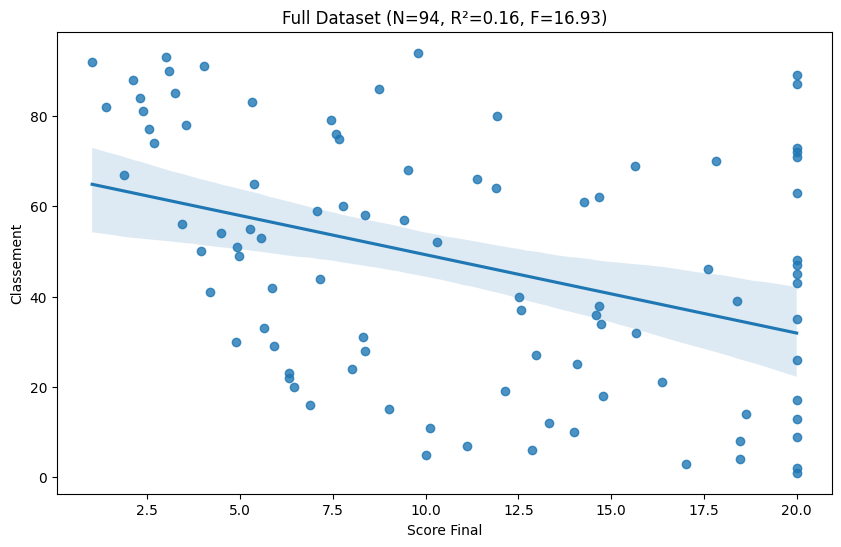

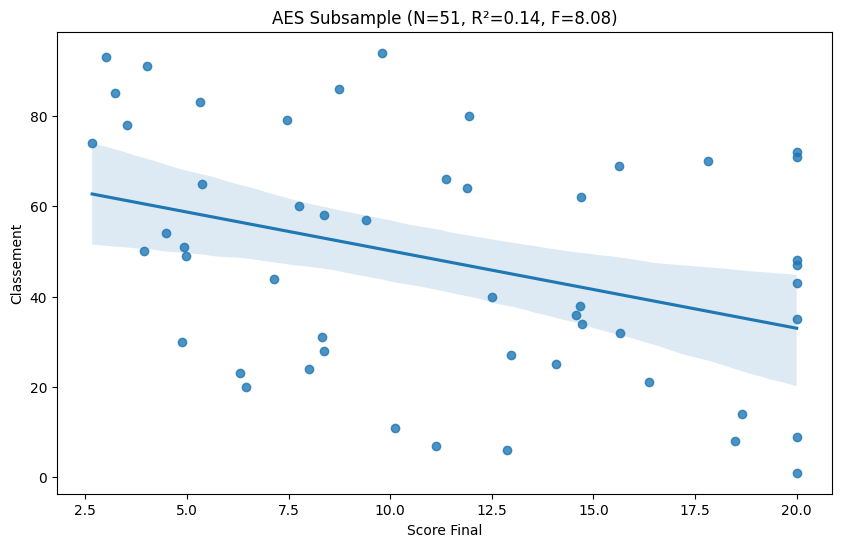

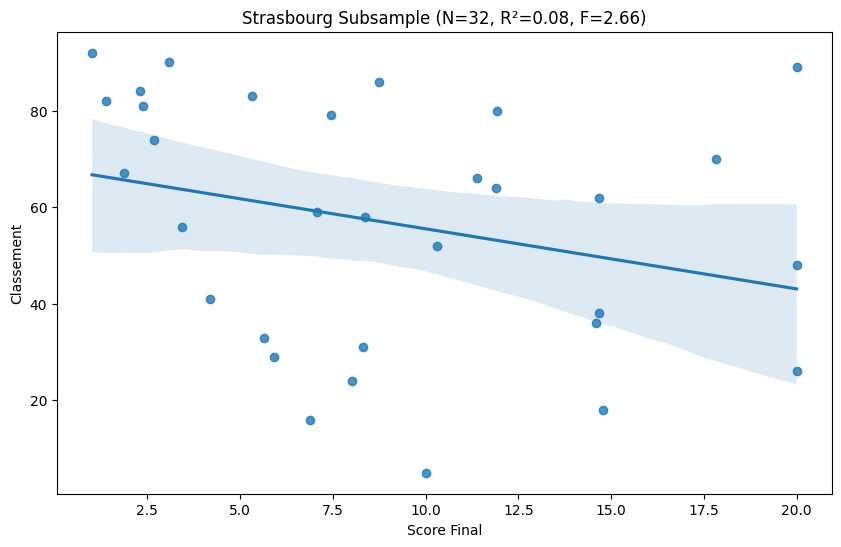

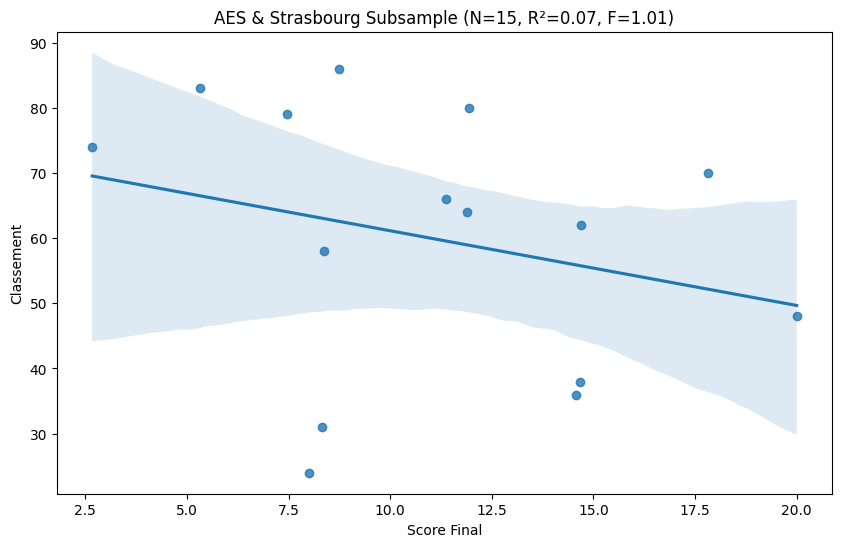

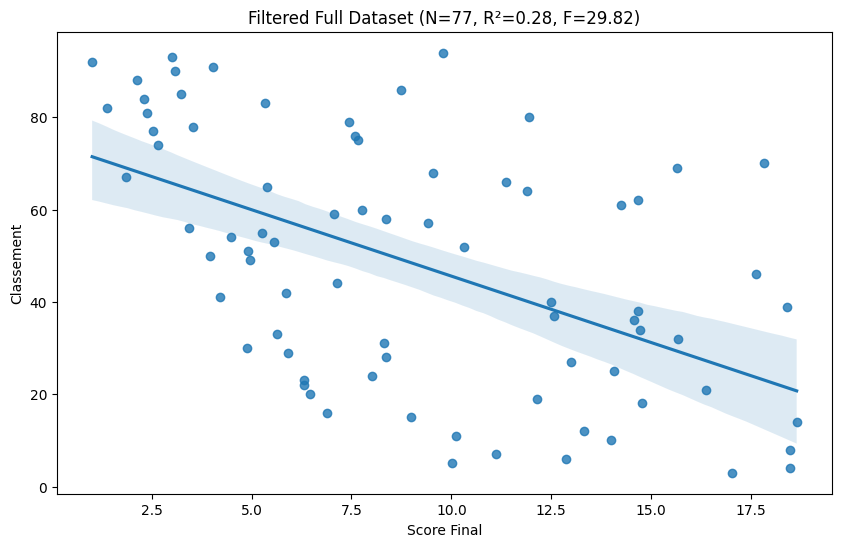

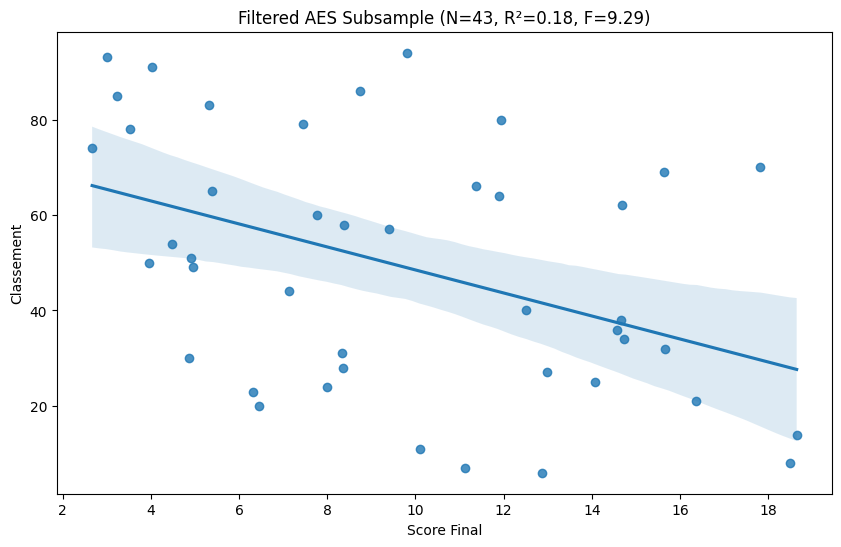

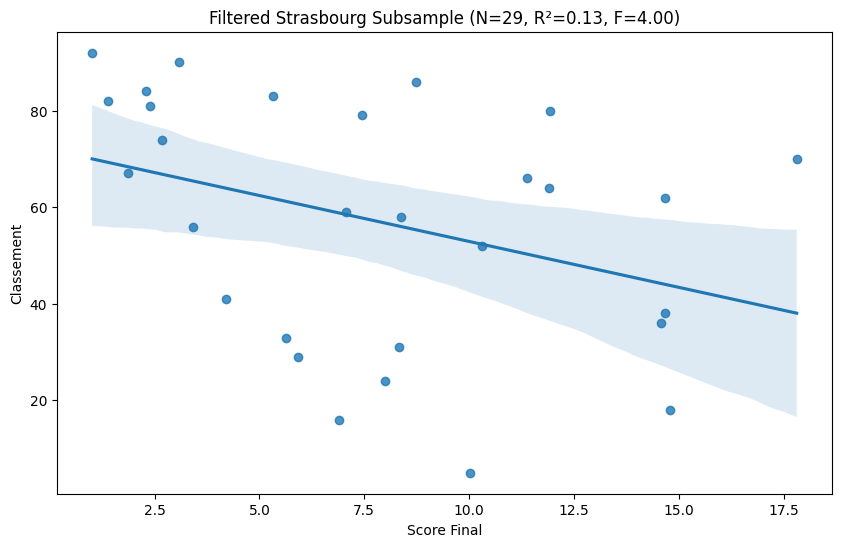

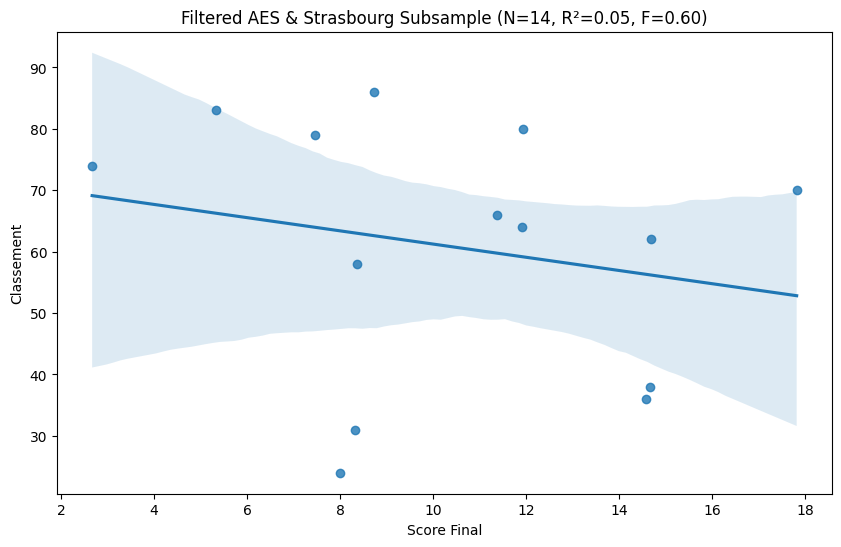

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Define a function to calculate and display the regression diagnostics
def display_regression_diagnostics(df, title):
    # Fit a linear regression model to the data
    model = sm.OLS(df['Classement'], sm.add_constant(df['Score Final']))
    results = model.fit()
    # Get the sample size, R², and F statistic
    N = results.nobs
    R2 = results.rsquared
    F = results.fvalue
    # Create a scatterplot with a linear regression line
    plt.figure(figsize=(10, 6))
    sns.regplot(data=df, x='Score Final', y='Classement')
    plt.title(f'{title} (N={N:.0f}, R²={R2:.2f}, F={F:.2f})')
    plt.show()

# Display the regression diagnostics for the full dataset
display_regression_diagnostics(merged_df, 'Full Dataset')

# Display the regression diagnostics for the 'aes' subsample
display_regression_diagnostics(aes_df, 'AES Subsample')

# Display the regression diagnostics for the 'Strasbourg' subsample
display_regression_diagnostics(strasbourg_df, 'Strasbourg Subsample')

# Display the regression diagnostics for the 'aes' and 'Strasbourg' subsample
display_regression_diagnostics(aes_strasbourg_df, 'AES & Strasbourg Subsample')

# Display the regression diagnostics for the filtered dataframes
display_regression_diagnostics(filtered_df, 'Filtered Full Dataset')
display_regression_diagnostics(filtered_aes_df, 'Filtered AES Subsample')
display_regression_diagnostics(filtered_strasbourg_df, 'Filtered Strasbourg Subsample')
display_regression_diagnostics(filtered_aes_strasbourg_df, 'Filtered AES & Strasbourg Subsample')

In [44]:
import numpy as np

# List of columns to clean
columns_to_clean = ['Moyenne Semestre 1 Licence (note/20)', 'Moyenne Semestre 2 Licence (note/20)', 
                    'Moyenne Semestre 3 Licence (note/20)', 'Moyenne Semestre 4 Licence (note/20)']

# Loop through the columns and clean each one
for column in columns_to_clean:
    # Replace 'N' with NaN
    df[column] = df[column].replace('N', np.nan)

    # Convert the column to numeric format, errors='coerce' will turn non-numeric values into NaN
    df[column] = pd.to_numeric(df[column], errors='coerce')

## Ex post analysis

       Moyenne Semestre 1 Licence (note/20)  \
count                            118.000000   
mean                              12.300280   
std                                1.872927   
min                                6.624000   
25%                               11.000000   
50%                               12.081000   
75%                               13.437000   
max                               19.000000   

       Moyenne Semestre 2 Licence (note/20)  \
count                            119.000000   
mean                              12.312412   
std                                1.761320   
min                                7.700000   
25%                               11.091500   
50%                               12.342000   
75%                               13.396500   
max                               18.000000   

       Moyenne Semestre 3 Licence (note/20)  \
count                            123.000000   
mean                              11.752951   
std        

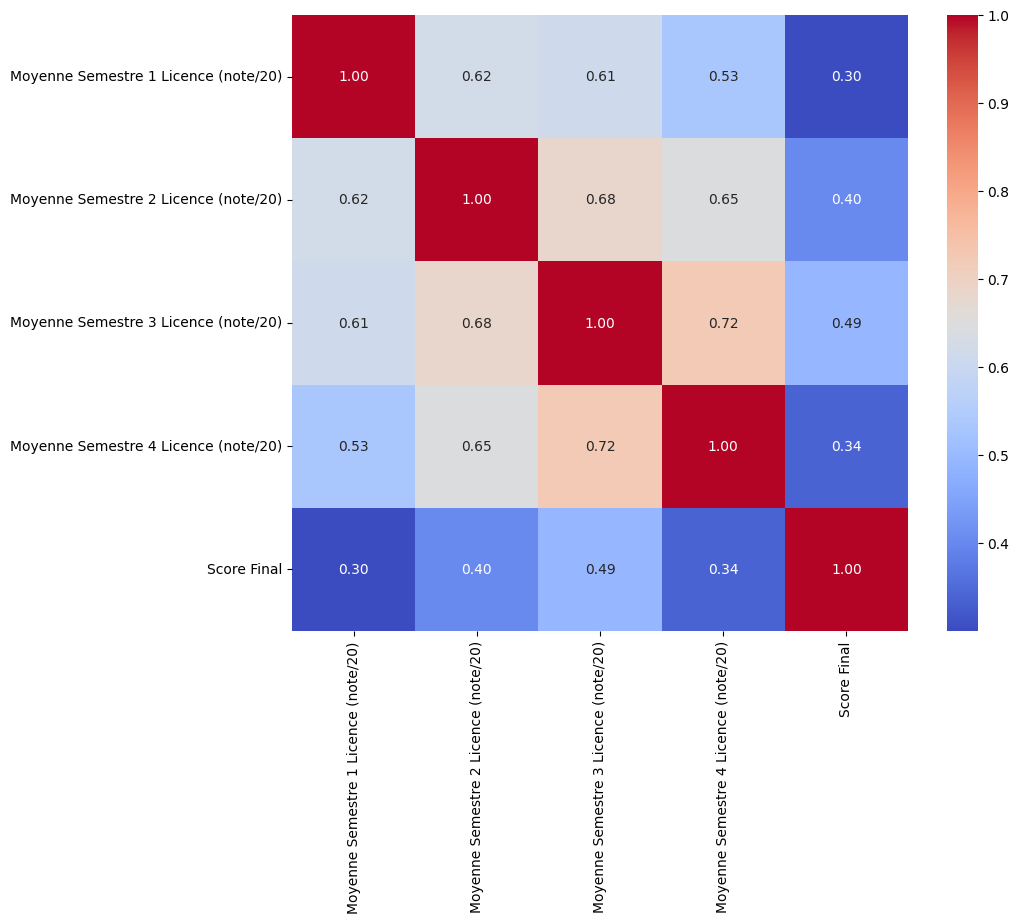

                            OLS Regression Results                            
Dep. Variable:            Score Final   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     8.371
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           6.69e-06
Time:                        00:57:15   Log-Likelihood:                -348.59
No. Observations:                 110   AIC:                             707.2
Df Residuals:                     105   BIC:                             720.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


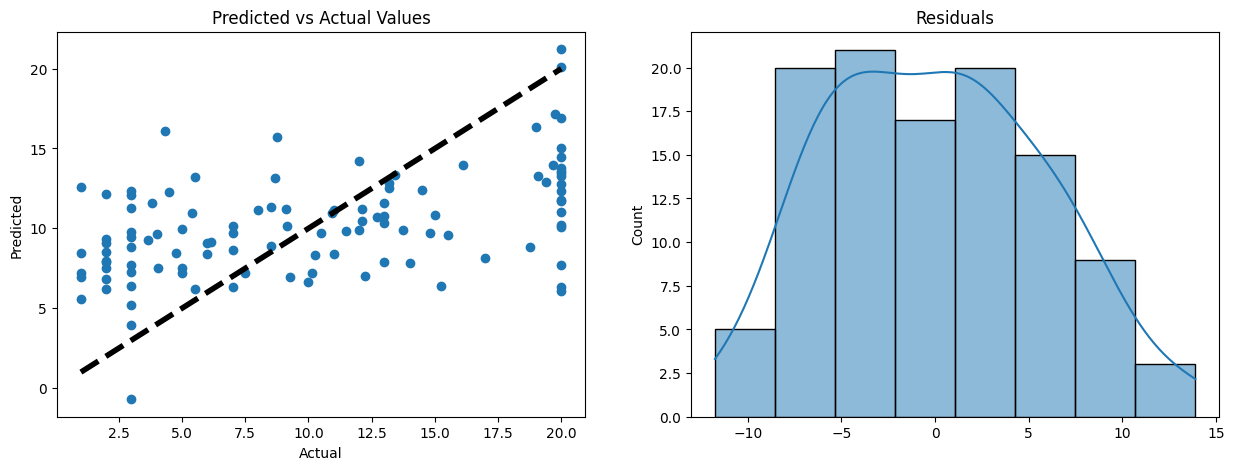

In [56]:
import statsmodels.api as sm

# Define your dependent variable (y) and independent variable (x)
y = df['Score Final']  
x = df[['Moyenne Semestre 1 Licence (note/20)', 'Moyenne Semestre 2 Licence (note/20)', 'Moyenne Semestre 3 Licence (note/20)', 'Moyenne Semestre 4 Licence (note/20)']]

x = x.replace([np.inf, -np.inf], np.nan)
x = x.dropna()
y = y.loc[x.index]  # Make sure y has the same rows as x

# Select the columns
selected_columns = df[['Moyenne Semestre 1 Licence (note/20)', 'Moyenne Semestre 2 Licence (note/20)', 
                       'Moyenne Semestre 3 Licence (note/20)', 'Moyenne Semestre 4 Licence (note/20)', 
                       'Score Final']]

# Descriptive statistics
print(selected_columns.describe())

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr = selected_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.show()

# Add a constant to the independent variable
x = sm.add_constant(x)

# Perform the regression
model = sm.OLS(y, x)

# Fit the model
results = model.fit()

# Print the summary of the regression results
print(results.summary())

# Get the predicted values
y_pred = results.predict(x)

# Create a figure and axes
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the predicted vs actual values
ax[0].scatter(y, y_pred)
ax[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax[0].set_xlabel('Actual')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Predicted vs Actual Values')

# Plot the residuals
sns.histplot(results.resid, kde=True, ax=ax[1])
ax[1].set_title('Residuals')

plt.show()